In [1]:
#imports
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from tabulate import tabulate
import xarray as xr
import dask
import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
bm = Basemap()
#import the relevant dataset
print('begin')
#Good_July.nc
path_to_file = '/fast/gmooers/Preprocessed_Data/One_Month_July/full_physics_essentials_valid_month02_targets.nc'
real_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Models/Good_July.nc'
test_ds = xr.open_dataset(path_to_file)

print('files imported')

heat_real_ds = real_ds.targets[:, :30].values
heat_test_ds = test_ds.Prediction[:, :30].values

moist_real_ds = real_ds.targets[:, 30:60].values
moist_test_ds = test_ds.Prediction[:, 30:60].values

times = real_ds.time.values

lats = real_ds.lat.values

lons = real_ds.lon.values

x = 144
y = 96
z = 30
t = int(len(heat_test_ds)/(x*y))
print(t)

SPCAM_Cycle = np.load("/fast/gmooers/RG_Paper_Data/Summer_Precip_Cycle_Truth.npy")

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


begin
files imported
2975


In [3]:
heat_reconstructed_targets = np.zeros(shape=(x, y, t, z))
heat_reconstructed_features = np.zeros(shape=(x, y, t, z))
moist_reconstructed_targets = np.zeros(shape=(x, y, t, z))
moist_reconstructed_features = np.zeros(shape=(x, y, t, z))
count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = heat_real_ds[count]
            B = heat_test_ds[count]
            C = moist_real_ds[count]
            D = moist_test_ds[count]
            heat_reconstructed_targets[k, j, i, :] = A 
            heat_reconstructed_features[k, j, i, :] = B 
            moist_reconstructed_targets[k, j, i, :] = C 
            moist_reconstructed_features[k, j, i, :] = D 
            count = count + 1

In [4]:
for i in range(len(heat_reconstructed_targets)):
    for j in range(len(heat_reconstructed_targets[i])):
        if np. isnan(SPCAM_Cycle[j,i]) == True:
            heat_reconstructed_targets[i,j,:,:] = np.nan
            heat_reconstructed_features[i,j,:,:] = np.nan
            moist_reconstructed_targets[i,j,:,:] = np.nan
            moist_reconstructed_features[i,j,:,:] = np.nan
            

(96, 144)


# Deseasonalization

In [5]:
heat_SPCAM5 = heat_reconstructed_targets[:,:,:,:]
heat_SPCAM5 = np.nanmean(np.nanmean(heat_SPCAM5, axis = 0),axis = 0)

heat_DNN = heat_reconstructed_features[:,:,:,:]
heat_DNN = np.nanmean(np.nanmean(heat_DNN, axis = 0),axis = 0)

moist_SPCAM5 = moist_reconstructed_targets[:,:,:,:]
moist_SPCAM5 = np.nanmean(np.nanmean(moist_SPCAM5, axis = 0),axis = 0)

moist_DNN = moist_reconstructed_features[:,:,:,:]
moist_DNN = np.nanmean(np.nanmean(moist_DNN, axis = 0),axis = 0)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


In [6]:
heat_SPCAM5_composite = np.zeros(shape=(96, 30))
heat_SPCAM5_composite[:,:] = np.nan

heat_DNN_composite = np.zeros(shape=(96, 30))
heat_DNN_composite[:,:] = np.nan

moist_SPCAM5_composite = np.zeros(shape=(96, 30))
moist_SPCAM5_composite[:,:] = np.nan

moist_DNN_composite = np.zeros(shape=(96, 30))
moist_DNN_composite[:,:] = np.nan

for i in range(96):
    heat_SPCAM5_composite[i,:] = np.nanmean(heat_SPCAM5[i::96,:],axis=0)
    heat_DNN_composite[i,:] = np.nanmean(heat_DNN[i::96,:],axis=0)
    moist_SPCAM5_composite[i,:] = np.nanmean(moist_SPCAM5[i::96,:],axis=0)
    moist_DNN_composite[i,:] = np.nanmean(moist_DNN[i::96,:],axis=0)

In [8]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
plev = np.array(others.variables['lev'])
ps = np.array(others.variables['PS'])
g = 9.81 #m/s^2
#print(plev)
hyai = np.array(others.variables['hyai'])
hybi = np.array(others.variables['hybi'])
#print(hyai.shape)
#print(hyai)
cp = 1004.0
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
P=P/100.
P = P[:-1]
print(P.shape)

(30,)


In [9]:
timing = np.linspace(0,23.75,96)
T, Z = np.meshgrid(timing, P)

In [10]:
import matplotlib
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

# Add land and sea masks

In [13]:
lat_list = np.linspace(-90.0, 90.0, 96)
lon_list = np.linspace(0.0, 357.5, 144)
longitudes = 144

ocean_DNN_heat = np.zeros(shape=(x, y, t, z))
ocean_SPCAM5_heat = np.zeros(shape=(x, y, t, z))
ocean_DNN_moist = np.zeros(shape=(x, y, t, z))
ocean_SPCAM5_moist = np.zeros(shape=(x, y, t, z))

ocean_DNN_heat[:,:,:,:] = np.nan
ocean_SPCAM5_heat[:,:,:,:] = np.nan
ocean_DNN_moist[:,:,:,:] = np.nan
ocean_SPCAM5_moist[:,:,:,:] = np.nan


for i in range(len(ocean_DNN_heat)):
    lon = lon_list[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(ocean_DNN_heat[i])):
        lat = lat_list[j]
        if bm.is_land(lon, lat) == False:
            ocean_DNN_heat[i, j, :,:] = heat_reconstructed_features[i, j, :,:]
            ocean_SPCAM5_heat[i, j, :,:] = heat_reconstructed_targets[i, j, :,:]
            ocean_DNN_moist[i, j, :,:] = moist_reconstructed_features[i, j, :,:]
            ocean_SPCAM5_moist[i, j, :,:] = moist_reconstructed_targets[i, j, :,:]
            
            
print("Land Mask Applied")

Land Mask Applied


In [14]:
lat_list = np.linspace(-90.0, 90.0, 96)
lon_list = np.linspace(0.0, 357.5, 144)
longitudes = 144

land_DNN_heat = np.zeros(shape=(x, y, t, z))
land_SPCAM5_heat = np.zeros(shape=(x, y, t, z))
land_DNN_moist = np.zeros(shape=(x, y, t, z))
land_SPCAM5_moist = np.zeros(shape=(x, y, t, z))

land_DNN_heat[:,:,:,:] = np.nan
land_SPCAM5_heat[:,:,:,:] = np.nan
land_DNN_moist[:,:,:,:] = np.nan
land_SPCAM5_moist[:,:,:,:] = np.nan


for i in range(len(land_DNN_heat)):
    lon = lon_list[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(land_DNN_heat[i])):
        lat = lat_list[j]
        if bm.is_land(lon, lat) == True:
            land_DNN_heat[i, j, :,:] = heat_reconstructed_features[i, j, :,:]
            land_SPCAM5_heat[i, j, :,:] = heat_reconstructed_targets[i, j, :,:]
            land_DNN_moist[i, j, :,:] = moist_reconstructed_features[i, j, :,:]
            land_SPCAM5_moist[i, j, :,:] = moist_reconstructed_targets[i, j, :,:]
            
            
print("Ocean Mask Applied")

Ocean Mask Applied


In [15]:
ocean_heat_SPCAM5 = ocean_SPCAM5_heat[:,:,:,:]
#ocean_heat_SPCAM5 = ocean_SPCAM5_heat[:,40:56,:,:]
ocean_heat_SPCAM5 = np.nanmean(np.nanmean(ocean_heat_SPCAM5, axis = 0),axis = 0)
land_heat_SPCAM5 = land_SPCAM5_heat[:,:,:,:]
#land_heat_SPCAM5 = land_DNN_heat[:,40:56,:,:]
land_heat_SPCAM5 = np.nanmean(np.nanmean(land_heat_SPCAM5, axis = 0),axis = 0)

ocean_heat_DNN = ocean_DNN_heat[:,:,:,:]
#ocean_heat_DNN = ocean_DNN_heat[:,40:56,:,:]
ocean_heat_DNN = np.nanmean(np.nanmean(ocean_heat_DNN, axis = 0),axis = 0)
land_heat_DNN = land_DNN_heat[:,:,:,:]
#land_heat_DNN = land_DNN_heat[:,40:56,:,:]
land_heat_DNN = np.nanmean(np.nanmean(land_heat_DNN, axis = 0),axis = 0)

ocean_moist_SPCAM5 = ocean_SPCAM5_moist[:,:,:,:]
#ocean_moist_SPCAM5 = ocean_SPCAM5_moist[:,40:56,:,:]
ocean_moist_SPCAM5 = np.nanmean(np.nanmean(ocean_moist_SPCAM5, axis = 0),axis = 0)
land_moist_SPCAM5 = land_SPCAM5_moist[:,:,:,:]
#land_moist_SPCAM5 = land_SPCAM5_moist[:,40:56,:,:]
land_moist_SPCAM5 = np.nanmean(np.nanmean(land_moist_SPCAM5, axis = 0),axis = 0)

ocean_moist_DNN = ocean_DNN_moist[:,:,:,:]
#ocean_moist_DNN = ocean_DNN_moist[:,40:56,:,:]
ocean_moist_DNN = np.nanmean(np.nanmean(ocean_moist_DNN, axis = 0),axis = 0)
land_moist_DNN = land_DNN_moist[:,:,:,:]
#land_moist_DNN = land_DNN_moist[:,40:56,:,:]
land_moist_DNN = np.nanmean(np.nanmean(land_moist_DNN, axis = 0),axis = 0)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of emp

In [17]:
ocean_heat_SPCAM5_composite = np.zeros(shape=(96, 30))
ocean_heat_SPCAM5_composite[:,:] = np.nan
land_heat_SPCAM5_composite = np.zeros(shape=(96, 30))
land_heat_SPCAM5_composite[:,:] = np.nan

ocean_heat_DNN_composite = np.zeros(shape=(96, 30))
ocean_heat_DNN_composite[:,:] = np.nan
land_heat_DNN_composite = np.zeros(shape=(96, 30))
land_heat_DNN_composite[:,:] = np.nan

ocean_moist_SPCAM5_composite = np.zeros(shape=(96, 30))
ocean_moist_SPCAM5_composite[:,:] = np.nan
land_moist_SPCAM5_composite = np.zeros(shape=(96, 30))
land_moist_SPCAM5_composite[:,:] = np.nan

ocean_moist_DNN_composite = np.zeros(shape=(96, 30))
ocean_moist_DNN_composite[:,:] = np.nan
land_moist_DNN_composite = np.zeros(shape=(96, 30))
land_moist_DNN_composite[:,:] = np.nan

for i in range(96):
    ocean_heat_SPCAM5_composite[i,:] = np.nanmean(ocean_heat_SPCAM5[i::96,:],axis=0)
    land_heat_SPCAM5_composite[i,:] = np.nanmean(land_heat_SPCAM5[i::96,:],axis=0)
    ocean_heat_DNN_composite[i,:] = np.nanmean(ocean_heat_DNN[i::96,:],axis=0)
    land_heat_DNN_composite[i,:] = np.nanmean(land_heat_DNN[i::96,:],axis=0)
    ocean_moist_SPCAM5_composite[i,:] = np.nanmean(ocean_moist_SPCAM5[i::96,:],axis=0)
    land_moist_SPCAM5_composite[i,:] = np.nanmean(land_moist_SPCAM5[i::96,:],axis=0)
    ocean_moist_DNN_composite[i,:] = np.nanmean(ocean_moist_DNN[i::96,:],axis=0)
    land_moist_DNN_composite[i,:] = np.nanmean(land_moist_DNN[i::96,:],axis=0)

# Deanomalize within data

In [23]:
mean_ocean_heat_SPCAM5_composite = np.nanmean(ocean_heat_SPCAM5_composite, axis = 0)
mean_ocean_heat_DNN_composite = np.nanmean(ocean_heat_DNN_composite, axis = 0)
mean_land_heat_SPCAM5_composite = np.nanmean(land_heat_SPCAM5_composite, axis=0)
mean_land_heat_DNN_composite = np.nanmean(land_heat_DNN_composite, axis=0)
mean_ocean_moist_SPCAM5_composite = np.nanmean(ocean_moist_SPCAM5_composite, axis=0)
mean_ocean_moist_DNN_composite = np.nanmean(ocean_moist_DNN_composite, axis=0)
mean_land_moist_SPCAM5_composite = np.nanmean(land_moist_SPCAM5_composite, axis=0)
mean_land_moist_DNN_composite = np.nanmean(land_moist_DNN_composite, axis=0)

anon_ocean_heat_SPCAM5_composite = np.zeros(shape=(96,30))
anon_ocean_heat_DNN_composite = np.zeros(shape=(96,30))
anon_land_heat_SPCAM5_composite = np.zeros(shape=(96,30))
anon_land_heat_DNN_composite = np.zeros(shape=(96,30))
anon_ocean_moist_SPCAM5_composite = np.zeros(shape=(96,30))
anon_ocean_moist_DNN_composite = np.zeros(shape=(96,30))
anon_land_moist_SPCAM5_composite = np.zeros(shape=(96,30))
anon_land_moist_DNN_composite = np.zeros(shape=(96,30))

for i in range(len(anon_ocean_heat_SPCAM5_composite)):
    anon_ocean_heat_SPCAM5_composite[i,:] = ocean_heat_SPCAM5_composite[i,:] - mean_ocean_heat_SPCAM5_composite
    anon_ocean_heat_DNN_composite[i,:] = ocean_heat_DNN_composite[i,:] - mean_ocean_heat_DNN_composite 
    anon_land_heat_SPCAM5_composite[i,:] = land_heat_SPCAM5_composite[i,:] - mean_land_heat_SPCAM5_composite
    anon_land_heat_DNN_composite[i,:] = land_heat_DNN_composite[i,:] - mean_land_heat_DNN_composite
    anon_ocean_moist_SPCAM5_composite[i, :] = ocean_moist_SPCAM5_composite[i,:] - mean_ocean_moist_SPCAM5_composite
    anon_ocean_moist_DNN_composite[i,:] = ocean_moist_DNN_composite[i,:] - mean_ocean_moist_DNN_composite
    anon_land_moist_SPCAM5_composite[i,:] = land_moist_SPCAM5_composite[i,:] - mean_land_moist_SPCAM5_composite
    anon_land_moist_DNN_composite[i,:] = land_moist_DNN_composite[i,:] - mean_land_moist_DNN_composite
    

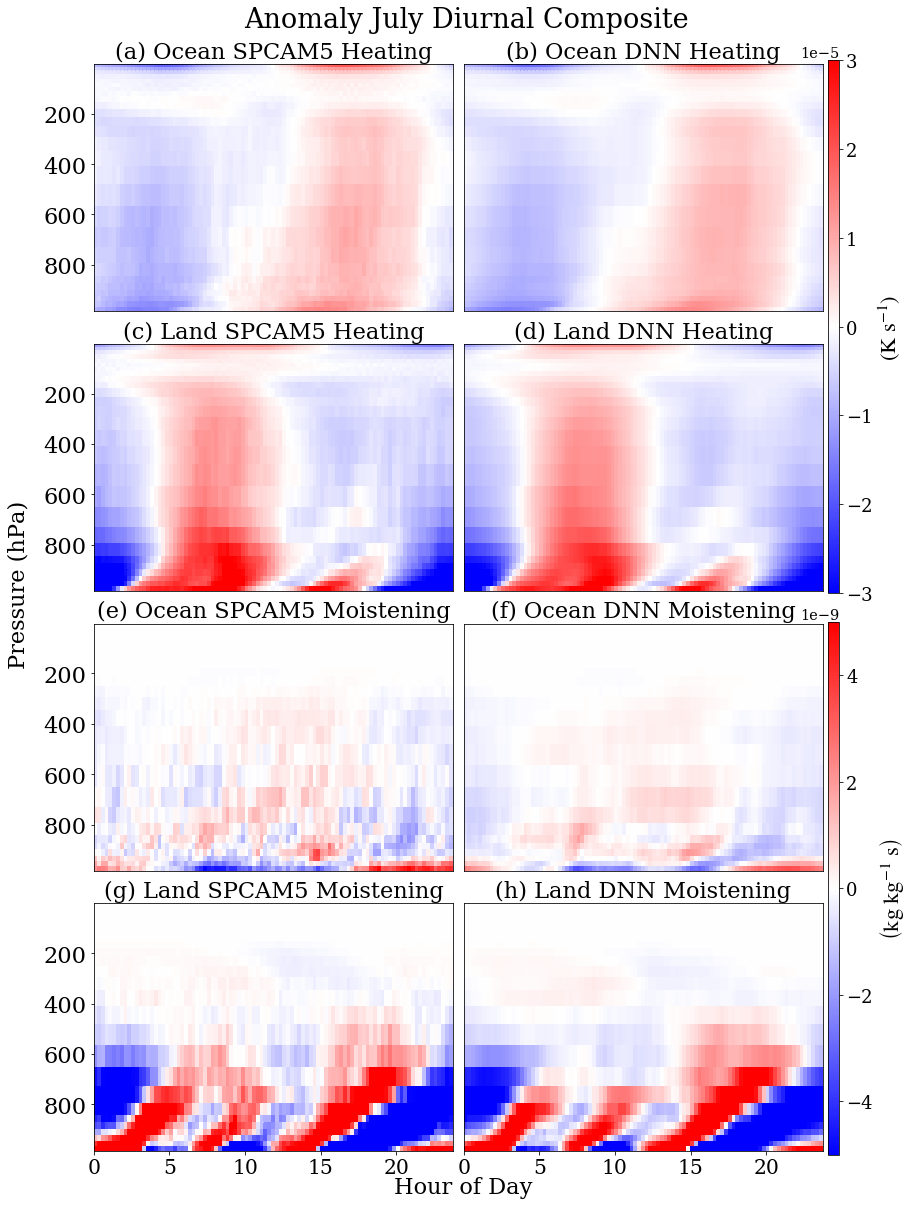

In [58]:
fig, ax = plt.subplots(4,2, figsize=(15,20))

cp = ax[0,0].pcolor(T, Z, anon_ocean_heat_SPCAM5_composite.T, cmap = 'bwr', vmin = -3.0e-5, vmax=3.0e-5)
ax[0,0].set_title("(a) Ocean SPCAM5 Heating", fontsize = fz)
ax[0,0].set_ylim(ax[0,0].get_ylim()[::-1])
ax[0,0].locator_params(nbins=8)
ax[0,0].tick_params(axis='x', labelsize=fz*0.9)
ax[0,0].set_xticks([])

cp = ax[0,1].pcolor(T, Z, anon_ocean_heat_DNN_composite.T, cmap = 'bwr', vmin =  -3.0e-5, vmax=3.0e-5)
ax[0,1].set_title("(b) Ocean DNN Heating", fontsize = fz)
ax[0,1].set_ylim(ax[0,1].get_ylim()[::-1])
ax[0,1].set_yticks([])
ax[0,1].set_xticks([])
ax[0,1].set_ylabel("Pressure (hPa)")
ax[0,1].yaxis.set_label_coords(-1.21,-1.1)
ax[0,1].locator_params(nbins=8)
ax[0,1].tick_params(axis='x', labelsize=fz*0.9)

cp = ax[1,0].pcolor(T, Z, anon_land_heat_SPCAM5_composite.T, cmap = 'bwr', vmin = -3.0e-5, vmax=3.0e-5)
ax[1,0].set_title("(c) Land SPCAM5 Heating", fontsize = fz)
ax[1,0].locator_params(nbins=8)
ax[1,0].tick_params(axis='x', labelsize=fz*0.9)
ax[1,0].set_ylim(ax[1,0].get_ylim()[::-1])
ax[1,0].set_xticks([])

cp = ax[1,1].pcolor(T, Z, anon_land_heat_DNN_composite.T, cmap = 'bwr', vmin = -3.0e-5, vmax=3.0e-5)
ax[1,1].set_title("(d) Land DNN Heating", fontsize = fz)
ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
ax[1,1].set_yticks([])
ax[1,1].set_xticks([])
#ax[1,1].set_xlabel("Hour of Day")
#ax[1,1].xaxis.set_label_coords(-0.001,-0.10)
ax[1,1].locator_params(nbins=8)
ax[1,1].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.5125, 0.01, 0.37])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{K} \ \mathrm{s^{-1}}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)


cp = ax[2,0].pcolor(T, Z, anon_ocean_moist_SPCAM5_composite.T, cmap = 'bwr', vmin=-0.5e-8, vmax=0.5e-8)
ax[2,0].set_title("(e) Ocean SPCAM5 Moistening", fontsize = fz)
ax[2,0].set_ylim(ax[2,0].get_ylim()[::-1])
ax[2,0].locator_params(nbins=8)
ax[2,0].tick_params(axis='x', labelsize=fz*0.9)
ax[2,0].set_xticks([])

cp = ax[2,1].pcolor(T, Z, anon_ocean_moist_DNN_composite.T, cmap = 'bwr', vmin=-0.5e-8, vmax=0.5e-8)
ax[2,1].set_title("(f) Ocean DNN Moistening", fontsize = fz)
ax[2,1].set_ylim(ax[2,1].get_ylim()[::-1])
ax[2,1].set_yticks([])
ax[2,1].set_xticks([])
#ax[1,1].set_xlabel("Hour of Day")
#ax[1,1].xaxis.set_label_coords(-0.10,-0.10)
ax[2,1].locator_params(nbins=8)
ax[2,1].tick_params(axis='x', labelsize=fz*0.9)

cp = ax[3,0].pcolor(T, Z, anon_land_moist_SPCAM5_composite.T, cmap = 'bwr', vmin=-0.5e-8, vmax=0.5e-8)
ax[3,0].set_title("(g) Land SPCAM5 Moistening", fontsize = fz)
ax[3,0].locator_params(nbins=8)
ax[3,0].tick_params(axis='x', labelsize=fz*0.9)
ax[3,0].set_ylim(ax[3,0].get_ylim()[::-1])

cp = ax[3,1].pcolor(T, Z, anon_land_moist_DNN_composite.T, cmap = 'bwr', vmin=-0.5e-8, vmax=0.5e-8)
ax[3,1].set_title("(h) Land DNN Moistening", fontsize = fz)
ax[3,1].set_ylim(ax[3,1].get_ylim()[::-1])
ax[3,1].set_yticks([])
ax[3,1].set_xlabel("Hour of Day")
ax[3,1].xaxis.set_label_coords(-0.001,-0.10)
ax[3,1].locator_params(nbins=8)
ax[3,1].tick_params(axis='x', labelsize=fz*0.9)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.1225, 0.01, 0.37])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{kg} \ \mathrm{kg^{-1}} \ \mathrm{s}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)



plt.suptitle("Anomaly July Diurnal Composite", y = 0.92, x=0.47)
plt.subplots_adjust(hspace=0.13, wspace=0.03)
plt.savefig("/fast/gmooers/RG_Paper_Figures/Figure21.png")
plt.savefig("/fast/gmooers/RG_Paper_Figures/Figure21.pdf")

In [ ]:
np.save("/fast/gmooers/RG_Paper_Data/X_vals.npy", T)
np.save("/fast/gmooers/RG_Paper_Data/Z_vals.npy", Z)
np.save("/fast/gmooers/RG_Paper_Data/anon_ocean_heat_SPCAM5_composite.npy", anon_ocean_heat_SPCAM5_composite)
np.save("/fast/gmooers/RG_Paper_Data/anon_ocean_heat_DNN_composite.npy", anon_ocean_heat_DNN_composite)
np.save("/fast/gmooers/RG_Paper_Data/anon_land_heat_SPCAM5_composite.npy", anon_land_heat_SPCAM5_composite)
np.save("/fast/gmooers/RG_Paper_Data/anon_land_heat_DNN_composite.npy", anon_land_heat_DNN_composite)
np.save("/fast/gmooers/RG_Paper_Data/anon_ocean_moist_SPCAM5_composite.npy", anon_ocean_moist_SPCAM5_composite)
np.save("/fast/gmooers/RG_Paper_Data/anon_ocean_moist_DNN_composite.npy", anon_ocean_moist_DNN_composite)
np.save("/fast/gmooers/RG_Paper_Data/anon_land_moist_SPCAM5_composite.npy", anon_land_moist_SPCAM5_composite)
np.save("/fast/gmooers/RG_Paper_Data/anon_land_moist_DNN_composite.npy", anon_land_moist_DNN_composite)

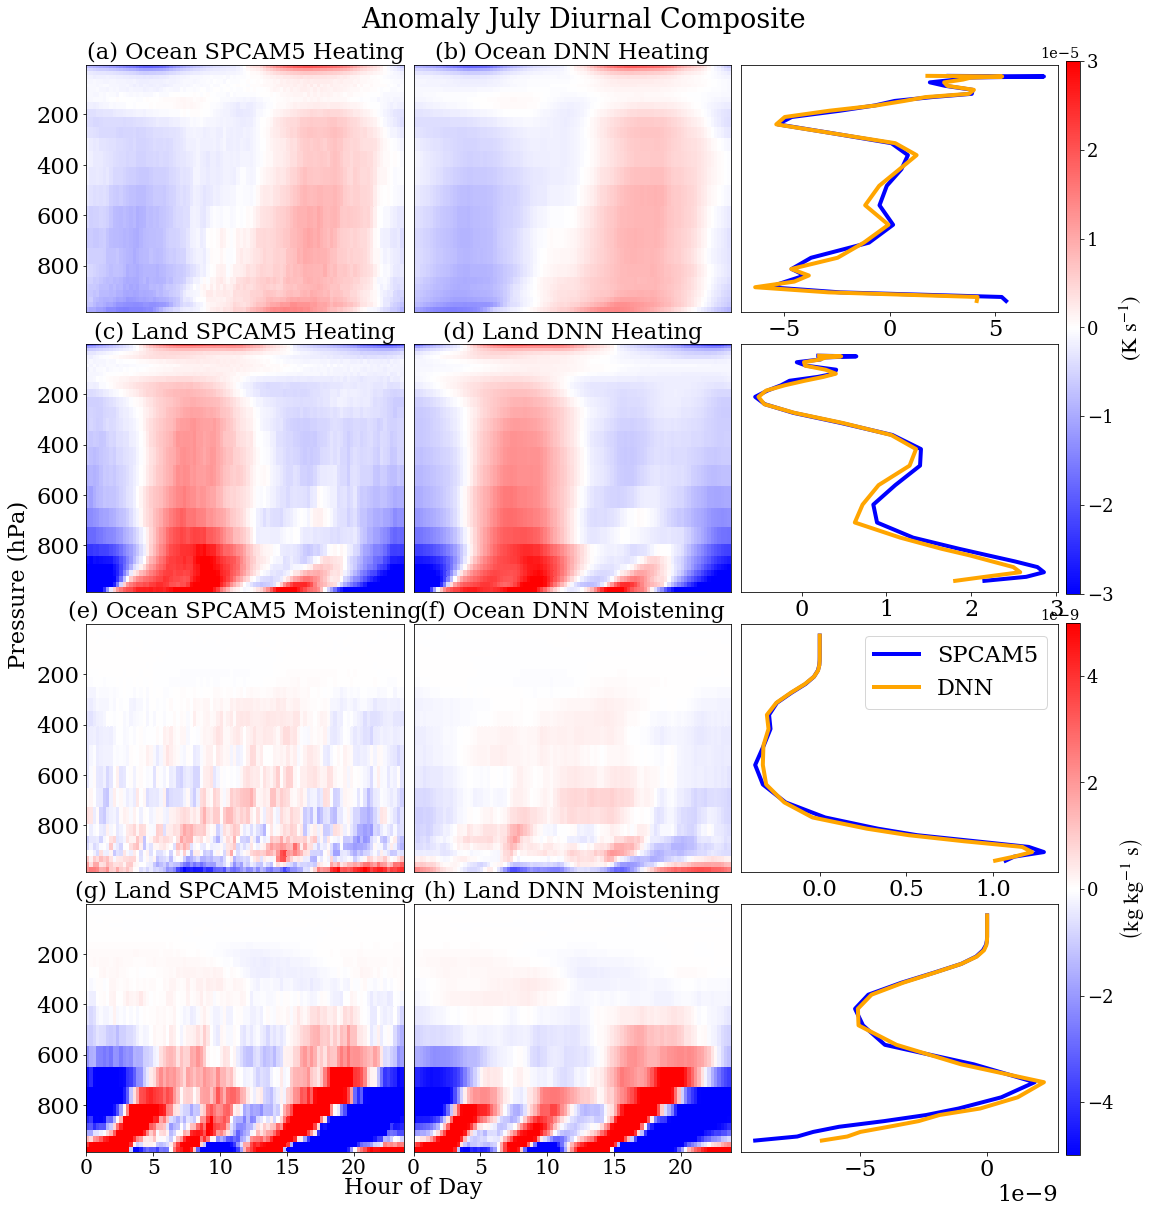

In [57]:
fig, ax = plt.subplots(4,3, figsize=(20,20))

cp = ax[0,0].pcolor(T, Z, anon_ocean_heat_SPCAM5_composite.T, cmap = 'bwr', vmin = -3.0e-5, vmax=3.0e-5)
ax[0,0].set_title("(a) Ocean SPCAM5 Heating", fontsize = fz)
ax[0,0].set_ylim(ax[0,0].get_ylim()[::-1])
ax[0,0].locator_params(nbins=8)
ax[0,0].tick_params(axis='x', labelsize=fz*0.9)
ax[0,0].set_xticks([])

cp = ax[0,1].pcolor(T, Z, anon_ocean_heat_DNN_composite.T, cmap = 'bwr', vmin =  -3.0e-5, vmax=3.0e-5)
ax[0,1].set_title("(b) Ocean DNN Heating", fontsize = fz)
ax[0,1].set_ylim(ax[0,1].get_ylim()[::-1])
ax[0,1].set_yticks([])
ax[0,1].set_xticks([])
ax[0,1].set_ylabel("Pressure (hPa)")
ax[0,1].yaxis.set_label_coords(-1.21,-1.1)
ax[0,1].locator_params(nbins=8)
ax[0,1].tick_params(axis='x', labelsize=fz*0.9)

#x = np.arange(0, len(mean_ocean_heat_SPCAM5_composite), 1)
ax[0,2].plot(mean_ocean_heat_SPCAM5_composite, P, color="blue", label = "SPCAM5")
ax[0,2].plot(mean_ocean_heat_DNN_composite, P, color="orange", label="DNN")
#ax[0,2].set_title("(c) Ocean DNN Heating", fontsize = fz)
#ax[0,2].set_ylim(-1e-5, 3e-5)
ax[0,2].set_ylim(ax[0,2].get_ylim()[::-1])
ax[0,2].set_yticks([])
ax[0,2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#ax[0,2].set_xticks([])
#ax[0,2].locator_params(nbins=8)
#ax[0,2].tick_params(axis='x', labelsize=fz*0.9)
#ax[0,2].legend()

cp = ax[1,0].pcolor(T, Z, anon_land_heat_SPCAM5_composite.T, cmap = 'bwr', vmin = -3.0e-5, vmax=3.0e-5)
ax[1,0].set_title("(c) Land SPCAM5 Heating", fontsize = fz)
ax[1,0].locator_params(nbins=8)
ax[1,0].tick_params(axis='x', labelsize=fz*0.9)
ax[1,0].set_ylim(ax[1,0].get_ylim()[::-1])
ax[1,0].set_xticks([])

cp = ax[1,1].pcolor(T, Z, anon_land_heat_DNN_composite.T, cmap = 'bwr', vmin = -3.0e-5, vmax=3.0e-5)
ax[1,1].set_title("(d) Land DNN Heating", fontsize = fz)
ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
ax[1,1].set_yticks([])
ax[1,1].set_xticks([])
#ax[1,1].set_xlabel("Hour of Day")
#ax[1,1].xaxis.set_label_coords(-0.001,-0.10)
ax[1,1].locator_params(nbins=8)
ax[1,1].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.5125, 0.01, 0.37])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{K} \ \mathrm{s^{-1}}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)

#x = np.arange(0, len(mean_ocean_heat_SPCAM5_composite), 1)
ax[1,2].plot(mean_land_heat_SPCAM5_composite, P, color="blue", label = "SPCAM5")
ax[1,2].plot(mean_land_heat_DNN_composite, P, color="orange", label="DNN")
#ax[0,2].set_title("(c) Ocean DNN Heating", fontsize = fz)
#ax[0,2].set_ylim(-1e-5, 3e-5)
ax[1,2].set_ylim(ax[1,2].get_ylim()[::-1])
ax[1,2].set_yticks([])
ax[1,2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#ax[0,2].set_xticks([])
#ax[0,2].locator_params(nbins=8)
#ax[0,2].tick_params(axis='x', labelsize=fz*0.9)
#ax[0,2].legend()


cp = ax[2,0].pcolor(T, Z, anon_ocean_moist_SPCAM5_composite.T, cmap = 'bwr', vmin=-0.5e-8, vmax=0.5e-8)
ax[2,0].set_title("(e) Ocean SPCAM5 Moistening", fontsize = fz)
ax[2,0].set_ylim(ax[2,0].get_ylim()[::-1])
ax[2,0].locator_params(nbins=8)
ax[2,0].tick_params(axis='x', labelsize=fz*0.9)
ax[2,0].set_xticks([])

cp = ax[2,1].pcolor(T, Z, anon_ocean_moist_DNN_composite.T, cmap = 'bwr', vmin=-0.5e-8, vmax=0.5e-8)
ax[2,1].set_title("(f) Ocean DNN Moistening", fontsize = fz)
ax[2,1].set_ylim(ax[2,1].get_ylim()[::-1])
ax[2,1].set_yticks([])
ax[2,1].set_xticks([])
#ax[1,1].set_xlabel("Hour of Day")
#ax[1,1].xaxis.set_label_coords(-0.10,-0.10)
ax[2,1].locator_params(nbins=8)
ax[2,1].tick_params(axis='x', labelsize=fz*0.9)

#x = np.arange(0, len(mean_ocean_heat_SPCAM5_composite), 1)
ax[2,2].plot(mean_ocean_moist_SPCAM5_composite, P, color="blue", label = "SPCAM5")
ax[2,2].plot(mean_ocean_moist_DNN_composite, P, color="orange", label="DNN")
#ax[0,2].set_title("(c) Ocean DNN Heating", fontsize = fz)
#ax[0,2].set_ylim(-1e-5, 3e-5)
ax[2,2].set_ylim(ax[2,2].get_ylim()[::-1])
ax[2,2].set_yticks([])
#ax[0,2].set_xticks([])
#ax[0,2].locator_params(nbins=8)
#ax[0,2].tick_params(axis='x', labelsize=fz*0.9)
ax[2,2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[2,2].legend()


cp = ax[3,0].pcolor(T, Z, anon_land_moist_SPCAM5_composite.T, cmap = 'bwr', vmin=-0.5e-8, vmax=0.5e-8)
ax[3,0].set_title("(g) Land SPCAM5 Moistening", fontsize = fz)
ax[3,0].locator_params(nbins=8)
ax[3,0].tick_params(axis='x', labelsize=fz*0.9)
ax[3,0].set_ylim(ax[3,0].get_ylim()[::-1])

cp = ax[3,1].pcolor(T, Z, anon_land_moist_DNN_composite.T, cmap = 'bwr', vmin=-0.5e-8, vmax=0.5e-8)
ax[3,1].set_title("(h) Land DNN Moistening", fontsize = fz)
ax[3,1].set_ylim(ax[3,1].get_ylim()[::-1])
ax[3,1].set_yticks([])
ax[3,1].set_xlabel("Hour of Day")
ax[3,1].xaxis.set_label_coords(-0.001,-0.10)
ax[3,1].locator_params(nbins=8)
ax[3,1].tick_params(axis='x', labelsize=fz*0.9)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.1225, 0.01, 0.37])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{kg} \ \mathrm{kg^{-1}} \ \mathrm{s}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)

#x = np.arange(0, len(mean_ocean_heat_SPCAM5_composite), 1)
ax[3,2].plot(mean_land_moist_SPCAM5_composite, P, color="blue", label = "SPCAM5")
ax[3,2].plot(mean_land_moist_DNN_composite, P, color="orange", label="DNN")
#ax[0,2].set_title("(c) Ocean DNN Heating", fontsize = fz)
#ax[0,2].set_ylim(-1e-5, 3e-5)
ax[3,2].set_ylim(ax[3,2].get_ylim()[::-1])
ax[3,2].set_yticks([])
ax[3,2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#ax[0,2].set_xticks([])
#ax[0,2].locator_params(nbins=8)
#ax[0,2].tick_params(axis='x', labelsize=fz*0.9)
#ax[3,2].legend()


plt.suptitle("Anomaly July Diurnal Composite", y = 0.92, x=0.47)
plt.subplots_adjust(hspace=0.13, wspace=0.03)
#plt.savefig("/fast/gmooers/RG_Paper_Figures/Figure21.png")
#plt.savefig("/fast/gmooers/RG_Paper_Figures/Figure21.pdf")